# Future Climate Risk Simulator

This is a climate risk economic analysis tool to analyze lifecycle costs of different alternatives in response to climate hazards. It is intended primarily for assessing transportation infrastructure assets.

The methodology is based in part on the FHWA TEACR study Machias case study:
https://www.fhwa.dot.gov/environment/sustainability/resilience/ongoing_and_current_research/teacr/dyke_bridge/

Here’s the basic structure:
-Takes as inputs:<br />
----Basic asset characteristics, including asset volume and growth rate, detour time/length, vehicle occupancy, etc.<br />
----Discount rate<br />
----Table of info about alternatives, including capital costs, replacement costs, O&M costs, construction dates, project open date, expected useful life, etc<br />
----Stressor cost functions for each alternative with damage costs and disruption durations<br />
----Sparse climate projections for multiple climate models and emissions scenarios (right now this is set up to be a limited set of projections for a few different return intervals and timeframes; e.g., 100-year, 25-year, and 5-year event for 2070-2099)<br />
-Uses the date inputs to set up a time series table<br />
-Interpolates the sparse climate projections between the years so that there are projections for each year<br />
-Parameterizes the Generalized Extreme Value (GEV) functions for each year and climate scenario using the different return intervals<br />
-Structures a Monte Carlo simulation with a table of random numbers with the dimensions X*Y where X is the number of analysis years and Y is the number of iterations in the Monte Carlo<br />
-Applies the random numbers to the parameterized GEVs to obtain an annual maximum event for each year for each climate scenario<br />
-Uses the annual maximum event magnitudes to look up damage and disruption values in the stressor cost function for each alternative<br />
-Calculates costs for each alternative for each year for each climate scenarios for each iteration of the Monte Carlo. Include capital costs, O&M costs, hazard damage costs, and hazard disruption costs<br />
-Applies discount rate to costs<br />
-Summarizes results across years and then across Monte Carlo iterations<br />
-Calculates summary statistics and produces graphs and tables.<br />

Tim Grose, timothy.h.grose@gmail.com

## Python Setup

In [1]:
#import packages
import pandas as pd
import numpy as np
import numpy.ma as ma
import os
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import scipy
from scipy.stats import genextreme as gev, genpareto
from scipy.interpolate import interp1d
from scipy.optimize import fsolve, root

In [2]:
#set base working directory variable to the path where this Notebook is located
base_path=os.getcwd()

## General Input and Setup

In [3]:
#general mods wishlist
#options treat avoided baseline costs as benefits
#discount rate sensitivity
#if asset totalled, probably wouldnt rebuild the same way
#other input variable sensitivity - independent distributions
#checks for valid inputs (eg sequential magcost entries)
#user interface
#accounting for non-climate benefits. simple version is adding total in. better option is allowing time series.
#add line chart of different options with cumulative discounted costs. would need to happen before percentiles are taken

In [4]:
#basic inputs
aadt=10000
aadt_base_year=2015
aadt_growth_rate=0.01
hours_perday=24
minutes_perhour=60
avg_vehicle_occupancy=1.8
avg_valueoftime_perhour=26
#might eventually want this by alternative, but leave for now.
net_detour_time_minutes=15
net_detour_length_miles=2
#add Traffic Data Info (AADT Composition, Fuel Price, Time value by mode, occupancy by mode, mode share of AADT, etc)
#would be good to eventually have construction cost inflation, fuel inflation, discount rate pre inflation, etc.

In [87]:
#discount rate
#constant for now. should add decay function option
#and explicitly factor in inflation. for now, this should be the real discount rate, with inflation removed, as is standard for BCA. http://bca.transportationeconomics.org/calculation-issues/discounting
#and allow sensitivity
discount_rate=.02

In [6]:
#set # of monte carlo simulations for future climate
n_sim=1000

In [7]:
#is there a no-action alternative being evaluated? 1 for yes, 0 for no
noaction_alt=1

In [8]:
net_detour_time_hours=net_detour_time_minutes/minutes_perhour

In [9]:
net_detour_time_cost=net_detour_time_hours*avg_valueoftime_perhour

## Alternatives Input and Setup

In [11]:
#alternatives info
#no action alternatives should have the is_existing_asset flag set to 1. they still need a construction start date
alternatives=pd.DataFrame([
    ['no_action',0,8000000,30000,2015,2015,2015,2015,80,1],
    ['reg_investment',10000000,8000000,10000,2015,2020,2025,2025,80,0],
    ['adapt_investment',12000000,9600000,10000,2015,2020,2025,2025,80,0]
],columns=['alternative_name','capital_cost','replacement_cost','om_annual_cost','project_start','construction_start','construction_end','asset_open','asset_life_years','is_existing_asset'])
#could also read csv for this
#probably want more precise dates

In [12]:
alternatives

,alternative_name,capital_cost,replacement_cost,om_annual_cost,project_start,construction_start,construction_end,asset_open,asset_life_years,is_existing_asset
0,no_action,0,8000000,30000,2015,2015,2015,2015,80,1
1,reg_investment,10000000,8000000,10000,2015,2020,2025,2025,80,0
2,adapt_investment,12000000,9600000,10000,2015,2020,2025,2025,80,0


In [13]:
alternatives['asset_end']=alternatives['asset_open']+alternatives['asset_life_years']

In [14]:
#user should check that vertical datums are consistent.

In [15]:
#stressor magnitude cost function
magcost=pd.DataFrame(np.array([
    [0,0,0,'no_action'],
    [10,.1,5,'no_action'],
    [12,.2,20,'no_action'],
    [13,.3,25,'no_action'],
    [14,.8,90,'no_action'],    
    [0,0,0,'reg_investment'],
    [9,0,0,'reg_investment'],
    [10,0,0,'reg_investment'],
    [11,0,0,'reg_investment'],
    [12,0,0,'reg_investment'],
    [13,.1,1,'reg_investment'],
    [14,.2,5,'reg_investment'],
    [15,.3,20,'reg_investment'],
    [16,.5,25,'reg_investment'],
    [17,.8,60,'reg_investment'],
    [0,0,0,'adapt_investment'],
    [14,0,0,'adapt_investment'],
    [15,.1,1,'adapt_investment'],
    [16,.2,5,'adapt_investment'],
    [17,.3,20,'adapt_investment'],
    [18,.5,30,'adapt_investment'],
    [19,.8,60,'adapt_investment'] 
]),columns=['magnitude_feet_navd88','damage_percent','time_days','alternative'])
#could also read csv for this

In [16]:
magcost[['magnitude_feet_navd88','damage_percent','time_days']]=magcost[['magnitude_feet_navd88','damage_percent','time_days']].apply(pd.to_numeric)

In [248]:
magcost

,magnitude_feet_navd88,damage_percent,time_days,alternative
0,0,0,0,no_action
1,10,0,5,no_action
2,12,0,20,no_action
3,13,0,25,no_action
4,14,1,90,no_action
5,0,0,0,reg_investment
6,9,0,0,reg_investment
7,10,0,0,reg_investment
8,11,0,0,reg_investment
9,12,0,0,reg_investment


## Climate Projection Input and Setup

In [17]:
#projections
#column names are annual probabilities
#units are feet navd88
projections=pd.DataFrame([
    [1950,2000,'historical','historical',9,12,14],
    [2010,2039,'model1','rcp85',10,13,15],
    [2040,2069,'model1','rcp85',11,15,18],
    [2070,2099,'model1','rcp85',12,17,19],
    [2010,2039,'model2','rcp85',11,14,15.5],
    [2040,2069,'model2','rcp85',11,17,19],
    [2070,2099,'model2','rcp85',12.5,17.5,23],
],columns=['start_year','end_year','gcm','rcp','.5','.1','.01'])
#could also read csv for this

In [18]:
projections['mid_year']=((projections['start_year']+projections['end_year'])/2).astype(int)

In [19]:
projections['mid_month']=1

In [20]:
projections['mid_day']=1

In [21]:
projections['mid_date']=pd.to_datetime(projections['mid_year']*10000+projections['mid_month']*100+projections['mid_day'],format='%Y%m%d')

## Analysis

### Prepare indices for multiple dimensions

In [22]:
gcmlist=projections['gcm'].unique().tolist()
rcplist=projections['rcp'].unique().tolist()
#includes historical. when we loop, start at 1!

In [23]:
alternativeslist=alternatives['alternative_name'].unique().tolist()

In [24]:
#get analysis timeframe
analysis_end=alternatives['asset_end'].max()
analysis_start=alternatives['project_start'].min()
projection_start=projections['mid_year'].loc[projections['gcm']!='historical'].min()

In [25]:
#create dataframe with rows representing each year in analysis timeframe
yrcalc=pd.DataFrame(pd.date_range(start=datetime(year=analysis_start,month=1,day=1),end=datetime(year=analysis_end,month=1,day=1),freq='AS'),columns=['date'])

### Structure years and interpolate climate scenarios

In [26]:
#decided on loops rather than xarrays, in part since the structure is somewhat irregular, with historical values getting reused across scenarios

In [27]:
#interpolate
#create results df
proj_annual=None
#start at 1 bc first element is historical for both gcmlist and rcplist
for i in range(1,len(gcmlist)):
    print (gcmlist[i])
    for j in range(1,len(rcplist)):
        print (rcplist[j])
        #combine historical data points and projections 
        proj_sparse=projections[((projections['gcm']=='historical')&(projections['rcp']=='historical'))
                        |((projections['gcm']==gcmlist[i])&(projections['rcp']==rcplist[j]))]
        #sticking with linear interpolation for now. extrapolation included.
        #scipy interpolation reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d
        #more background: https://en.wikipedia.org/wiki/Interpolation
        interp50=interp1d(proj_sparse['mid_year'],proj_sparse['.5'],kind='linear',fill_value='extrapolate')
        interp10=interp1d(proj_sparse['mid_year'],proj_sparse['.1'],kind='linear',fill_value='extrapolate')
        interp01=interp1d(proj_sparse['mid_year'],proj_sparse['.01'],kind='linear',fill_value='extrapolate')
        #create annual projections df from sparse projection df
        proj_annual_temp=yrcalc.merge(proj_sparse,left_on='date',right_on='mid_date',how='left')
        #infill gcm and rcp, including historical
        proj_annual_temp['gcm']=gcmlist[i]
        proj_annual_temp['rcp']=rcplist[j]
        #grab year only
        proj_annual_temp['year']=proj_annual_temp['date'].dt.year
        #apply interpolations
        proj_annual_temp['.5']=interp50(proj_annual_temp['year'])
        proj_annual_temp['.1']=interp10(proj_annual_temp['year'])
        proj_annual_temp['.01']=interp01(proj_annual_temp['year'])
        #drop columns and any rows with years before analysis start date. should ultimately only keep date or year. probably date so that we dont lose monthly analysis functionality
        proj_annual_temp=proj_annual_temp.loc[proj_annual_temp['year']>=analysis_start].drop(
            ['start_year','end_year','mid_year','mid_month','mid_day','mid_date'],axis=1)
        #reset the index
        proj_annual_temp.reset_index(drop=True,inplace=True)
        #concat to results df
        proj_annual=pd.concat([proj_annual,proj_annual_temp])
#reset the index after concatenating all
proj_annual.reset_index(drop=True,inplace=True)

model1
rcp85
model2
rcp85


### Parameterize

In [28]:
#parameterisation notes
#keep in mind that we're now trying to reconstruct a gev that was used to derive these events in the first place. better to save parameters if theyre available
#https://stats.stackexchange.com/questions/6022/estimating-a-distribution-based-on-three-percentiles
#https://cran.r-project.org/web/packages/rriskDistributions/rriskDistributions.pdf
#look at fit.perc
#https://en.wikipedia.org/wiki/Generalized_extreme_value_distribution#Link_to_Fr%C3%A9chet,_Weibull_and_Gumbel_families
#appears that Frechet is best distribution of GEV family (has lower limit), though could also be Weibull

In [29]:
#the low number acts as bottom support.
#return intervals are currently hard coded. should be flexible based on inputs.
def nonlin_eval(x,q):
    return q-gev.ppf([0.0001,.5,.9,.99],x[0],loc=x[1],scale=x[2])

In [30]:
#parameterize each projection
#return intervals are currently hard coded. should be flexible based on inputs.
#apply instead of loop?
proj_annual['gev_param_size']=None
proj_annual['gev_param_loc']=None
proj_annual['gev_param_scale']=None
for i in range(len(proj_annual)):
    root_solve=root(nonlin_eval,[0,10,1],
                    [.01,proj_annual['.5'].iloc[i],proj_annual['.1'].iloc[i],proj_annual['.01'].iloc[i]],
                    method='lm')
    proj_annual['gev_param_size'].iloc[i],proj_annual['gev_param_loc'].iloc[i],proj_annual['gev_param_scale'].iloc[i]=root_solve.x

C:\Users\groseth\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [31]:
#diagnostics example
#y=gev.rvs(0.32977078,loc=8.1139722,scale=2.47700966,size=1000)
#plt.hist(y)

### Perform simulations

In [32]:
#create array of random numbers from uniform distribution for monte carlo
# number of years x number of simulations
mc_rand=np.random.rand(analysis_end-analysis_start+1,n_sim)

In [33]:
#tile the array so it repeats vertically number of rcps (minus historical) * number of gcms (minus historical)
mc_rand_tile=np.tile(mc_rand,((len(gcmlist)-1)*(len(rcplist)-1),1))

In [34]:
#generate percent point functions for a set of gev parameters across an (a-year x b-simulation) array
def gevcast (rand_array,gev_size,gev_loc,gev_scale):
    return gev.ppf(rand_array,gev_size.astype('float64'),loc=gev_loc.astype('float64'),scale=gev_scale.astype('float64'))

In [35]:
#apply gevcast using gev parameters for each year x number of simulations
mc_rand_result=np.apply_along_axis(gevcast,0,mc_rand_tile,gev_size=proj_annual.gev_param_size,gev_loc=proj_annual.gev_param_loc,gev_scale=proj_annual.gev_param_scale)

In [36]:
#convert any negative values to 0
mc_rand_result=mc_rand_result.clip(min=0)

In [37]:
#convert monte carlo annual maxima simulations to df
mc_rand_df=pd.DataFrame(mc_rand_result)

In [38]:
#qaqc for one dimension
#gev.ppf(mc_rand[:,0],proj_annual.gev_param_size.astype('float64'),loc=proj_annual.gev_param_loc.astype('float64'),scale=proj_annual.gev_param_scale.astype('float64'))

### Calculate Costs

In [39]:
alternatives

,alternative_name,capital_cost,replacement_cost,om_annual_cost,project_start,construction_start,construction_end,asset_open,asset_life_years,is_existing_asset,asset_end
0,no_action,0,8000000,30000,2015,2015,2015,2015,80,1,2095
1,reg_investment,10000000,8000000,10000,2015,2020,2025,2025,80,0,2105
2,adapt_investment,12000000,9600000,10000,2015,2020,2025,2025,80,0,2105


In [40]:
alternatives['capcost_duration']=alternatives['construction_end']-alternatives['project_start']
alternatives['proj_start_dt']=pd.to_datetime(alternatives['project_start']*10000+projections['mid_month']*100+projections['mid_day'],format='%Y%m%d')
alternatives['const_end_dt']=pd.to_datetime(alternatives['construction_end']*10000+projections['mid_month']*100+projections['mid_day'],format='%Y%m%d')
alternatives['asset_open_dt']=pd.to_datetime(alternatives['asset_open']*10000+projections['mid_month']*100+projections['mid_day'],format='%Y%m%d')
alternatives['asset_end_dt']=pd.to_datetime(alternatives['asset_end']*10000+projections['mid_month']*100+projections['mid_day'],format='%Y%m%d')

In [58]:
alt_annual=None
for k in range(len(alternativeslist)):
    #create temporary dataframe
    alt_annual_temp=pd.DataFrame(data=proj_annual[['date','gcm','rcp']])
    
    #basics
    alt_annual_temp['alt_name']=alternatives['alternative_name'].iloc[k]
    alt_annual_temp['is_existing_asset']=alternatives['is_existing_asset'].iloc[k]
    
    #cap cost
    alt_annual_temp['capital_cost']=0
    if alternatives['is_existing_asset']!=1:
        alt_capcost_duration=alternatives['capcost_duration'].iloc[k]
        mask = (alt_annual_temp['date'] >= alternatives['proj_start_dt'].iloc[k]) & (alt_annual_temp['date'] < alternatives['const_end_dt'].iloc[k])
        alt_annual_temp['capital_cost'].loc[mask]=alternatives['capital_cost'].iloc[k]/alt_capcost_duration
    
    #replacement and om costs
    alt_annual_temp['replacement_cost']=alternatives['replacement_cost'][alternatives['is_existing_asset']==1][0]
    alt_annual_temp['om_cost']=alternatives['om_annual_cost'][alternatives['is_existing_asset']==1][0]
    mask = (alt_annual_temp['date'] >= alternatives['asset_open_dt'].iloc[k]) & (alt_annual_temp['date'] <= alternatives['asset_end_dt'].iloc[k])
    alt_annual_temp['om_cost'].loc[mask]=alternatives['om_annual_cost'].iloc[k]
    alt_annual_temp['replacement_cost'].loc[mask]=alternatives['replacement_cost'].iloc[k]
    
    #other columns
    alt_annual_temp['aadt']=(aadt*((1+aadt_growth_rate)**(alt_annual_temp['date'].dt.year-aadt_base_year))).round(0)
    alt_annual_temp['daily_person_trips']=alt_annual_temp['aadt']*avg_vehicle_occupancy
    alt_annual_temp['day_disruption_time_cost']=net_detour_time_cost*alt_annual_temp['daily_person_trips']
    #need to include fuel eventually
    alt_annual_temp['day_disruption_cost']=alt_annual_temp['day_disruption_time_cost']
    alt_annual=pd.concat([alt_annual,alt_annual_temp])

C:\Users\groseth\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [163]:
#join mc_rand_df to alt_annual on index
alt_annual_mc=alt_annual.merge(mc_rand_df,left_index=True,right_index=True)
#reset index
alt_annual_mc.reset_index(drop=True,inplace=True)

In [164]:
#define lookup function that looks up a value in an lookup table, 
#then finds the closest value equal to or less than the lookup value, 
#and then returns a list of result vectors
def round_down_lookup(lu_value,lu_df,lu_vector_name,result_vector_names):
    #lookup and sort results by absolute difference btw lookup value and lookup vector
    sorted_results=lu_df.iloc[(lu_df[lu_vector_name]-lu_value).abs().argsort()]
    #filter lookup vector to numbers less than or equal to lookup value
    lessthan_sorted_results=sorted_results.loc[(sorted_results[lu_vector_name]-lu_value)<=0]
    #return the first row of result vector(s) as a list
    return lessthan_sorted_results[result_vector_names][0:1].values.tolist()[0]

In [165]:
#apply round_down_lookup to every row and applicable column
#this is the longest runtime of any of the code blocks. refactor.
for i in range(n_sim):
    print (i)
    for k in range(len(alternativeslist)):
        print (k)
        alt_annual_mc[i].loc[alt_annual_mc['alt_name']==alternativeslist[k]]=alt_annual_mc[i].loc[alt_annual_mc['alt_name']==alternativeslist[k]].apply(round_down_lookup,args=(
        magcost.loc[magcost['alternative']==alternativeslist[k]],
        'magnitude_feet_navd88',['damage_percent','time_days']))

0
0


C:\Users\groseth\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


1
2
1
0
1
2
2
0
1
2
3
0
1
2
4
0
1
2
5
0
1
2
6
0
1
2
7
0
1
2
8
0
1
2
9
0
1
2
10
0
1
2
11
0
1
2
12
0
1
2
13
0
1
2
14
0
1
2
15
0
1
2
16
0
1
2
17
0
1
2
18
0
1
2
19
0
1
2
20
0
1
2
21
0
1
2
22
0
1
2
23
0
1
2
24
0
1
2
25
0
1
2
26
0
1
2
27
0
1
2
28
0
1
2
29
0
1
2
30
0
1
2
31
0
1
2
32
0
1
2
33
0
1
2
34
0
1
2
35
0
1
2
36
0
1
2
37
0
1
2
38
0
1
2
39
0
1
2
40
0
1
2
41
0
1
2
42
0
1
2
43
0
1
2
44
0
1
2
45
0
1
2
46
0
1
2
47
0
1
2
48
0
1
2
49
0
1
2
50
0
1
2
51
0
1
2
52
0
1
2
53
0
1
2
54
0
1
2
55
0
1
2
56
0
1
2
57
0
1
2
58
0
1
2
59
0
1
2
60
0
1
2
61
0
1
2
62
0
1
2
63
0
1
2
64
0
1
2
65
0
1
2
66
0
1
2
67
0
1
2
68
0
1
2
69
0
1
2
70
0
1
2
71
0
1
2
72
0
1
2
73
0
1
2
74
0
1
2
75
0
1
2
76
0
1
2
77
0
1
2
78
0
1
2
79
0
1
2
80
0
1
2
81
0
1
2
82
0
1
2
83
0
1
2
84
0
1
2
85
0
1
2
86
0
1
2
87
0
1
2
88
0
1
2
89
0
1
2
90
0
1
2
91
0
1
2
92
0
1
2
93
0
1
2
94
0
1
2
95
0
1
2
96
0
1
2
97
0
1
2
98
0
1
2
99
0
1
2
100
0
1
2
101
0
1
2
102
0
1
2
103
0
1
2
104
0
1
2
105
0
1
2
106
0
1
2
107
0
1
2
108
0
1
2
109
0
1
2
110
0
1
2
111


2
831
0
1
2
832
0
1
2
833
0
1
2
834
0
1
2
835
0
1
2
836
0
1
2
837
0
1
2
838
0
1
2
839
0
1
2
840
0
1
2
841
0
1
2
842
0
1
2
843
0
1
2
844
0
1
2
845
0
1
2
846
0
1
2
847
0
1
2
848
0
1
2
849
0
1
2
850
0
1
2
851
0
1
2
852
0
1
2
853
0
1
2
854
0
1
2
855
0
1
2
856
0
1
2
857
0
1
2
858
0
1
2
859
0
1
2
860
0
1
2
861
0
1
2
862
0
1
2
863
0
1
2
864
0
1
2
865
0
1
2
866
0
1
2
867
0
1
2
868
0
1
2
869
0
1
2
870
0
1
2
871
0
1
2
872
0
1
2
873
0
1
2
874
0
1
2
875
0
1
2
876
0
1
2
877
0
1
2
878
0
1
2
879
0
1
2
880
0
1
2
881
0
1
2
882
0
1
2
883
0
1
2
884
0
1
2
885
0
1
2
886
0
1
2
887
0
1
2
888
0
1
2
889
0
1
2
890
0
1
2
891
0
1
2
892
0
1
2
893
0
1
2
894
0
1
2
895
0
1
2
896
0
1
2
897
0
1
2
898
0
1
2
899
0
1
2
900
0
1
2
901
0
1
2
902
0
1
2
903
0
1
2
904
0
1
2
905
0
1
2
906
0
1
2
907
0
1
2
908
0
1
2
909
0
1
2
910
0
1
2
911
0
1
2
912
0
1
2
913
0
1
2
914
0
1
2
915
0
1
2
916
0
1
2
917
0
1
2
918
0
1
2
919
0
1
2
920
0
1
2
921
0
1
2
922
0
1
2
923
0
1
2
924
0
1
2
925
0
1
2
926
0
1
2
927
0
1
2
928
0
1
2
929
0
1
2
930
0
1


In [225]:
#convert lists to hazard damage and disruption costs plus o&m costs
for i in range(n_sim):
    print (i)
    alt_annual_mc[i]=alt_annual_mc[i].str[0]*alt_annual_mc['replacement_cost']+alt_annual_mc[i].str[1]*alt_annual_mc['day_disruption_cost']+alt_annual_mc['om_cost']

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [227]:
#remove alt hazard costs before asset open. if there's a no action, take no action costs before project asset opens
for k in range(len(alternativeslist)):
    mask=(alt_annual_mc['date']<alternatives['asset_open_dt'].iloc[k])
    if noaction_alt==1:
        no_action_earlyyears=alt_annual_mc.loc[(alt_annual_mc['is_existing_asset']==1)&mask, list(range(n_sim))].values
        alt_annual_mc.loc[(alt_annual_mc.alt_name==alternatives['alternative_name'].iloc[k])&mask, list(range(n_sim))]=no_action_earlyyears
    else:
        alt_annual_mc.loc[(alt_annual_mc.alt_name==alternatives['alternative_name'].iloc[k])&mask, list(range(n_sim))]=0

In [228]:
#add applicable capital cost after correcting early hazard and o&m costs
for i in range(n_sim):
    print (i)
    alt_annual_mc[i]=alt_annual_mc[i]+alt_annual_mc['capital_cost']

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [247]:
alt_annual_mc.iloc[:,0:20]

,date,gcm,rcp,alt_name,is_existing_asset,capital_cost,replacement_cost,om_cost,aadt,daily_person_trips,day_disruption_time_cost,day_disruption_cost,0,1,2,3,4,5,6,7
0,2015-01-01,model1,rcp85,no_action,1,0,8000000,30000,"10,000","18,000","117,000","117,000","30,000","3,970,000","3,970,000","30,000","1,415,000","3,970,000","5,355,000","5,355,000"
1,2015-01-01,model1,rcp85,reg_investment,0,"1,000,000",8000000,30000,"10,000","18,000","117,000","117,000","1,030,000","4,970,000","4,970,000","1,030,000","2,415,000","4,970,000","6,355,000","6,355,000"
2,2015-01-01,model1,rcp85,adapt_investment,0,"1,200,000",8000000,30000,"10,000","18,000","117,000","117,000","1,230,000","5,170,000","5,170,000","1,230,000","2,615,000","5,170,000","6,555,000","6,555,000"
3,2016-01-01,model1,rcp85,no_action,1,0,8000000,30000,"10,100","18,180","118,170","118,170","1,420,850","1,420,850","1,420,850","1,420,850","3,993,400","1,420,850","30,000","30,000"
4,2016-01-01,model1,rcp85,reg_investment,0,"1,000,000",8000000,30000,"10,100","18,180","118,170","118,170","2,420,850","2,420,850","2,420,850","2,420,850","4,993,400","2,420,850","1,030,000","1,030,000"
5,2016-01-01,model1,rcp85,adapt_investment,0,"1,200,000",8000000,30000,"10,100","18,180","118,170","118,170","2,620,850","2,620,850","2,620,850","2,620,850","5,193,400","2,620,850","1,230,000","1,230,000"
6,2017-01-01,model1,rcp85,no_action,1,0,8000000,30000,"10,201","18,362","119,352","119,352","30,000","30,000","30,000","1,426,758","30,000","30,000","30,000","30,000"
7,2017-01-01,model1,rcp85,reg_investment,0,"1,000,000",8000000,30000,"10,201","18,362","119,352","119,352","1,030,000","1,030,000","1,030,000","2,426,758","1,030,000","1,030,000","1,030,000","1,030,000"
8,2017-01-01,model1,rcp85,adapt_investment,0,"1,200,000",8000000,30000,"10,201","18,362","119,352","119,352","1,230,000","1,230,000","1,230,000","2,626,758","1,230,000","1,230,000","1,230,000","1,230,000"
9,2018-01-01,model1,rcp85,no_action,1,0,8000000,30000,"10,303","18,545","120,545","120,545","30,000","1,432,726","4,040,902","1,432,726","30,000","30,000","4,040,902","30,000"


In [230]:
#create copy for discounted cost
alt_annual_mc_discount=alt_annual_mc.copy()

In [231]:
#discount rate multiplier
alt_annual_mc_discount['discount_multiplier']=1/((1+discount_rate)**(alt_annual_mc_discount.date.dt.year-analysis_start))

In [232]:
#apply discount rate
for i in range(n_sim):
    print (i)
    alt_annual_mc_discount[i]=alt_annual_mc_discount[i]*alt_annual_mc_discount['discount_multiplier']

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [233]:
alt_annual_mc_discount

,date,gcm,rcp,alt_name,is_existing_asset,capital_cost,replacement_cost,om_cost,aadt,daily_person_trips,...,991,992,993,994,995,996,997,998,999,discount_multiplier
0,2015-01-01,model1,rcp85,no_action,1,0,8000000,30000,"10,000","18,000",...,"30,000","1,415,000","30,000","1,415,000","30,000","1,415,000","16,960,000","30,000","1,415,000",1
1,2015-01-01,model1,rcp85,reg_investment,0,"1,000,000",8000000,30000,"10,000","18,000",...,"1,030,000","2,415,000","1,030,000","2,415,000","1,030,000","2,415,000","17,960,000","1,030,000","2,415,000",1
2,2015-01-01,model1,rcp85,adapt_investment,0,"1,200,000",8000000,30000,"10,000","18,000",...,"1,230,000","2,615,000","1,230,000","2,615,000","1,230,000","2,615,000","18,160,000","1,230,000","2,615,000",1
3,2016-01-01,model1,rcp85,no_action,1,0,8000000,30000,"10,100","18,180",...,"29,412","16,730,686","29,412","29,412","3,915,098","1,392,990","29,412","3,915,098","29,412",1
4,2016-01-01,model1,rcp85,reg_investment,0,"1,000,000",8000000,30000,"10,100","18,180",...,"1,009,804","17,711,078","1,009,804","1,009,804","4,895,490","2,373,382","1,009,804","4,895,490","1,009,804",1
5,2016-01-01,model1,rcp85,adapt_investment,0,"1,200,000",8000000,30000,"10,100","18,180",...,"1,205,882","17,907,157","1,205,882","1,205,882","5,091,569","2,569,461","1,205,882","5,091,569","1,205,882",1
6,2017-01-01,model1,rcp85,no_action,1,0,8000000,30000,"10,201","18,362",...,"3,861,048","28,835","1,371,356","3,861,048","3,861,048","28,835","28,835","28,835","1,371,356",1
7,2017-01-01,model1,rcp85,reg_investment,0,"1,000,000",8000000,30000,"10,201","18,362",...,"4,822,216","990,004","2,332,525","4,822,216","4,822,216","990,004","990,004","990,004","2,332,525",1
8,2017-01-01,model1,rcp85,adapt_investment,0,"1,200,000",8000000,30000,"10,201","18,362",...,"5,014,450","1,182,238","2,524,758","5,014,450","5,014,450","1,182,238","1,182,238","1,182,238","2,524,758",1
9,2018-01-01,model1,rcp85,no_action,1,0,8000000,30000,"10,303","18,545",...,"28,270","28,270","28,270","28,270","28,270","28,270","28,270","1,350,089","1,350,089",1


## Summarize results

In [234]:
#sum across years
alt_annual_mc_discount_presentcost=alt_annual_mc_discount.groupby(['alt_name','gcm','rcp'])[list(range(n_sim))].sum()
alt_annual_mc_presentcost=alt_annual_mc.groupby(['alt_name','gcm','rcp'])[list(range(n_sim))].sum()

In [235]:
alt_annual_mc_discount_presentcost

0           1           2           3    \
alt_name         gcm    rcp                                                     
adapt_investment model1 rcp85  31,881,453  42,535,348  57,635,547  38,351,714   
                 model2 rcp85  62,932,210  66,326,442  81,555,607  63,444,990   
no_action        model1 rcp85 211,729,071 215,639,773 230,165,771 196,563,420   
                 model2 rcp85 270,195,656 283,167,739 276,889,414 246,362,816   
reg_investment   model1 rcp85  68,762,217  76,446,215  94,756,475  67,245,622   
                 model2 rcp85  96,918,296 109,973,232 115,985,598  97,441,177   

                                      4           5           6           7    \
alt_name         gcm    rcp                                                     
adapt_investment model1 rcp85  33,965,615  45,365,393  50,720,539  46,317,772   
                 model2 rcp85  68,322,709  83,253,450  84,317,126  70,379,762   
no_action        model1 rcp85 199,304,892 229,579,378 261,917,343 218,950,485   
                 model2 rcp85 271,067,828 291,465,270 314,852,181 289,840,262   
reg_investment   model1 rcp85  60,372,190  77,004,113  84,037,316  73,651,318   
                 model2 rcp85 105,097,613 122,811,958 134,431,593 110,954,424   

                                      8           9    ...         990  \
alt_name         gcm    rcp                            ...               
adapt_investment model1 rcp85  40,353,550  30,791,150  ...  31,859,466   
                 model2 rcp85  73,272,730  51,967,138  ...  66,024,546   
no_action        model1 rcp85 217,580,872 221,617,734  ... 181,268,580   
                 model2 rcp85 275,160,647 255,555,449  ... 236,864,395   
reg_investment   model1 rcp85  82,377,024  59,270,338  ...  64,063,722   
                 model2 rcp85 104,379,662  92,131,426  ... 101,377,076   

                                      991         992         993         994  \
alt_name         gcm    rcp                                                     
adapt_investment model1 rcp85  32,330,377  63,423,623  37,973,016  81,232,929   
                 model2 rcp85  49,392,585 106,978,257  72,125,947 121,979,593   
no_action        model1 rcp85 199,709,971 266,592,230 177,350,449 254,291,851   
                 model2 rcp85 256,932,726 331,482,759 204,586,652 316,213,297   
reg_investment   model1 rcp85  64,652,406 106,281,809  72,045,250 126,552,444   
                 model2 rcp85  90,647,949 151,416,891  94,178,683 160,670,399   

                                      995         996         997         998  \
alt_name         gcm    rcp                                                     
adapt_investment model1 rcp85  44,211,744  40,139,519  77,512,874  25,751,190   
                 model2 rcp85  89,115,010  73,538,009 104,466,442  41,856,473   
no_action        model1 rcp85 241,960,923 216,407,206 263,557,970 242,571,773   
                 model2 rcp85 324,300,466 267,655,530 303,838,357 294,343,622   
reg_investment   model1 rcp85  82,716,179  72,854,670 111,249,649  54,570,949   
                 model2 rcp85 133,948,449 111,773,342 144,206,832  82,493,383   

                                      999  
alt_name         gcm    rcp                
adapt_investment model1 rcp85  43,472,842  
                 model2 rcp85  70,556,037  
no_action        model1 rcp85 227,814,418  
                 model2 rcp85 265,987,497  
reg_investment   model1 rcp85  73,840,201  
                 model2 rcp85 111,425,882  

[6 rows x 1000 columns]

In [236]:
discount_presentcost_summary=alt_annual_mc_discount_presentcost.drop(columns=list(range(n_sim)))
present_cost_summary=alt_annual_mc_presentcost.drop(columns=list(range(n_sim)))

In [237]:
#take percentiles
results_percentiles=[5,50,95]
for p in results_percentiles:
    fld_name=str(p)+'th_percentile'
    discount_presentcost_summary[fld_name]=np.percentile(alt_annual_mc_discount_presentcost,p,axis=1)
    present_cost_summary[fld_name]=np.percentile(alt_annual_mc_presentcost,p,axis=1)

In [238]:
#set display options for number formats
pd.options.display.float_format = '{:,.0F}'.format

In [239]:
discount_presentcost_summary

5th_percentile  50th_percentile  \
alt_name         gcm    rcp                                      
adapt_investment model1 rcp85      28,188,793       42,210,866   
                 model2 rcp85      46,009,047       71,459,893   
no_action        model1 rcp85     164,763,235      215,852,448   
                 model2 rcp85     206,435,055      266,963,042   
reg_investment   model1 rcp85      51,051,066       73,231,071   
                 model2 rcp85      76,635,509      108,406,324   

                               95th_percentile  
alt_name         gcm    rcp                     
adapt_investment model1 rcp85       64,526,047  
                 model2 rcp85      102,056,877  
no_action        model1 rcp85      273,289,838  
                 model2 rcp85      330,559,462  
reg_investment   model1 rcp85      101,791,485  
                 model2 rcp85      146,795,979

In [240]:
present_cost_summary

5th_percentile  50th_percentile  \
alt_name         gcm    rcp                                      
adapt_investment model1 rcp85      51,200,198       89,019,046   
                 model2 rcp85      97,956,658      160,977,197   
no_action        model1 rcp85     487,866,482      633,510,853   
                 model2 rcp85     558,183,802      714,599,294   
reg_investment   model1 rcp85     124,884,832      193,246,047   
                 model2 rcp85     185,201,870      268,858,017   

                               95th_percentile  
alt_name         gcm    rcp                     
adapt_investment model1 rcp85      137,407,693  
                 model2 rcp85      239,037,926  
no_action        model1 rcp85      794,742,427  
                 model2 rcp85      881,961,291  
reg_investment   model1 rcp85      274,021,342  
                 model2 rcp85      367,417,188

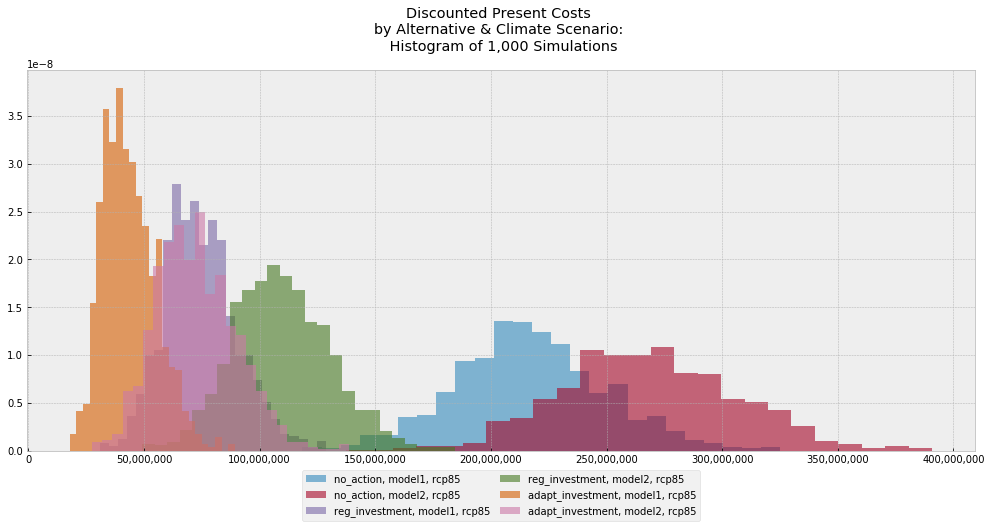

In [242]:
#overlapping histogram plot
plt.style.use('bmh')
matplotlib.rcParams['figure.figsize'] = [17,7]
fig, ax = plt.subplots()
for k in range(len(alternativeslist)):
    for i in range(1,len(gcmlist)):
        for j in range(1,len(rcplist)):
            current_plt=alt_annual_mc_discount_presentcost[list(range(n_sim))].loc[
                (alternativeslist[k],gcmlist[i],rcplist[j])]
            ax.hist(current_plt, histtype="stepfilled",bins=25, alpha=.6, density=True, 
                    label=(alternativeslist[k]+', '+gcmlist[i]+', '+rcplist[j]))
ax.legend()
plt.legend(loc='lower center',columnspacing=1,
           ncol=2, borderaxespad=-7)
#ax.ticklabel_format(style='plain',axis='x')
ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_title("Discounted Present Costs \nby Alternative & Climate Scenario: \n Histogram of 1,000 Simulations",pad=20)
plt.show()

In [243]:
#violin plot axis labels
def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)

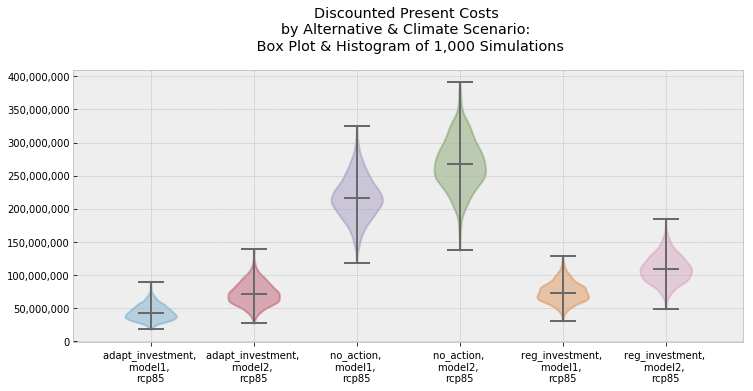

In [244]:
#violin plot
plt.style.use('bmh')
matplotlib.rcParams['figure.figsize'] = [12,5]
fig, ax = plt.subplots()
vplot=ax.violinplot(alt_annual_mc_discount_presentcost, showmeans=False,showmedians=True)
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
xlabel_list=[]
for i in range(0,len(alt_annual_mc_discount_presentcost)):
    xlabel_list.append(
        alt_annual_mc_discount_presentcost.index[i][0]+', \n'+
        alt_annual_mc_discount_presentcost.index[i][1]+', \n'+
        alt_annual_mc_discount_presentcost.index[i][2])
set_axis_style(ax, xlabel_list)
colors=['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']
for patch, color in zip(vplot['bodies'], colors): 
    patch.set_facecolor(color)
    patch.set_edgecolor(color)
    patch.set_linewidth(2)
for partname in ('cbars','cmins','cmaxes','cmedians'):
    vp = vplot[partname]
    vp.set_edgecolor('dimgrey')
ax.set_title("Discounted Present Costs \nby Alternative & Climate Scenario: \n Box Plot & Histogram of 1,000 Simulations",pad=20)
plt.show()

In [245]:
discount_presentcost_summary

5th_percentile  50th_percentile  \
alt_name         gcm    rcp                                      
adapt_investment model1 rcp85      28,188,793       42,210,866   
                 model2 rcp85      46,009,047       71,459,893   
no_action        model1 rcp85     164,763,235      215,852,448   
                 model2 rcp85     206,435,055      266,963,042   
reg_investment   model1 rcp85      51,051,066       73,231,071   
                 model2 rcp85      76,635,509      108,406,324   

                               95th_percentile  
alt_name         gcm    rcp                     
adapt_investment model1 rcp85       64,526,047  
                 model2 rcp85      102,056,877  
no_action        model1 rcp85      273,289,838  
                 model2 rcp85      330,559,462  
reg_investment   model1 rcp85      101,791,485  
                 model2 rcp85      146,795,979